# Modelo de detección de emojis

Este notebook entrena un modelo de **red neuronal convolucional (CNN)** para reconocer diferentes expresiones de emojis a partir de imágenes.  
Incluye todo el flujo: carga de datos, entrenamiento, evaluación, exportación a formato ONNX y pruebas de predicción.


## Instalación de dependencias

In [ ]:
# %pip install tf2onnx
# %pip install onnxruntime
# %pip install --upgrade protobuf==3.20.3
# %pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importar librerías

In [ ]:
# librerias
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array
import tf2onnx
import onnxruntime as ort
from PIL import Image
import cv2



# Carga y preprocesamiento del dataset

Se cargan las imágenes desde la carpeta dataset_final, usando la función image_dataset_from_directory de Keras.

Se divide el dataset en 80% entrenamiento y 20% validación, y las imágenes se redimensionan a 64×64 píxeles.

Además, se normalizan los valores de píxel a rango [0, 1] para mejorar la convergencia del modelo.

In [54]:
# Ruta al dataset
data_dir = "./dataset_final"

# Parámetros
img_height, img_width = 64, 64  # puedes ajustar según tus imágenes
batch_size = 32

# Cargar dataset dividido en entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# #calcular el total de imágenes en cada conjunto
# total_train = sum(1 for _ in train_ds.unbatch())
# total_val = sum(1 for _ in val_ds.unbatch())

# print("Total de imágenes de entrenamiento:", total_train)
# print("Total de imágenes de validación:", total_val)

# Guardar las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

# Normalizar después
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

Found 7062 files belonging to 7 classes.
Using 5650 files for training.
Found 7062 files belonging to 7 classes.
Using 1412 files for validation.
Clases: ['confundido', 'enojado', 'feliz', 'muerto', 'neutral', 'sorprendida', 'triste']


# Definicion del modelo CNN

Se construye una red convolucional secuencial con varias capas:
- Conv2D + MaxPooling2D: extracción de características.
- Flatten + Dense(128, relu): capas densas para clasificación.
- Dropout(0.3): reduce sobreajuste.
- Dense(num_classes, softmax): salida final con probabilidad por clase.

El modelo se compila con:
- Optimizador Adam
- Pérdida sparse_categorical_crossentropy
- Métrica accuracy


In [55]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Entrenamiento del modelo

In [56]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4526 - loss: 1.4177 - val_accuracy: 0.7018 - val_loss: 0.8334
Epoch 2/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7901 - loss: 0.5956 - val_accuracy: 0.8938 - val_loss: 0.3213
Epoch 3/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9094 - loss: 0.2681 - val_accuracy: 0.9568 - val_loss: 0.1466
Epoch 4/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9545 - loss: 0.1399 - val_accuracy: 0.9674 - val_loss: 0.1084
Epoch 5/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9688 - loss: 0.1047 - val_accuracy: 0.9618 - val_loss: 0.1127
Epoch 6/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9786 - loss: 0.0730 - val_accuracy: 0.9844 - val_loss: 0.0666
Epoch 7/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9851 - loss: 0.0452 - val_accuracy: 0.9759 - val_loss: 0.0919
Epoch 8/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9848 - loss: 0.0467 - val_acc

# Visualización de desempeño

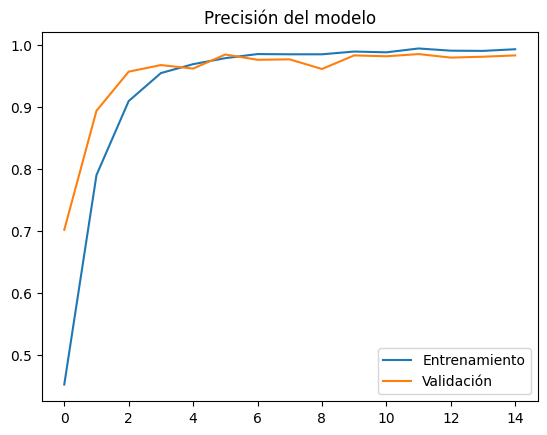

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

import matplotlib.pyplot as plt
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.legend()
plt.title('Precisión del modelo')
plt.show()


Lo que se observa en el gráfico es que el modelo alcanza una presición cercana al 100%, con curvas en el entrenamiento y validación similares, lo que nos indica bajo sobreajuste

# Evaluación con matriz de confusión

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

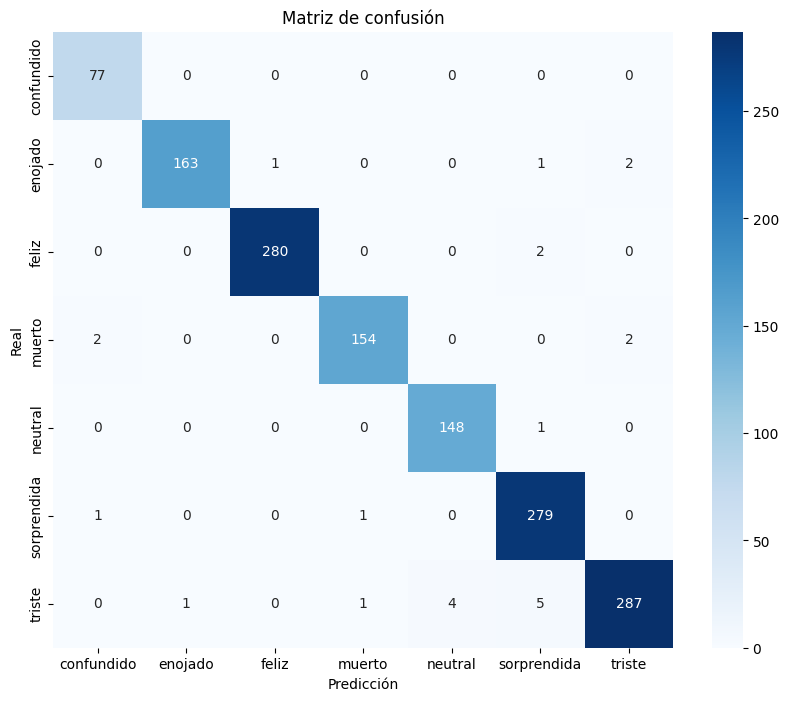

Reporte de clasificación:
              precision    recall  f1-score   support

  confundido       0.96      1.00      0.98        77
     enojado       0.99      0.98      0.98       167
       feliz       1.00      0.99      0.99       282
      muerto       0.99      0.97      0.98       158
     neutral       0.97      0.99      0.98       149
 sorprendida       0.97      0.99      0.98       281
      triste       0.99      0.96      0.97       298

    accuracy                           0.98      1412
   macro avg       0.98      0.98      0.98      1412
weighted avg       0.98      0.98      0.98      1412



In [58]:

# Obtener predicciones sobre el set de validación
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))


Las predicciones se generan sobre el conjunto de validación y se calcula la matriz de confusión para analizar los errores por clase y se ve que el modelo tiene un buen desempeño en todas las categorias. Además, el reporte de clasificación muestra un promedio de presición, recall y F1-score de 0.98 lo que demuestra que el modelo parece ser muy confiable

# Prueba con imagenes nuevas

In [83]:

import os

INPUT_ROOT = "./pruebas"

# Iterate files in the folder instead of iterating the string path
for filename in os.listdir(INPUT_ROOT):
    img_path = os.path.join(INPUT_ROOT, filename)

    try:
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        pred_class = class_names[np.argmax(predictions)]
        print(f"Imagen: {img_path} - Predicción: {pred_class}")
    except PermissionError:
        print(f"Sin permiso para leer: {img_path}")
    except Exception as e:
        print(f"Error al procesar {img_path}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Imagen: ./pruebas\confundido.png - Predicción: confundido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Imagen: ./pruebas\confundido7.png - Predicción: confundido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Imagen: ./pruebas\enojado3.png - Predicción: enojado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Imagen: ./pruebas\enojado4.png - Predicción: enojado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Imagen: ./pruebas\feliz2.png - Predicción: feliz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Imagen: ./pruebas\muerto.png - Predicción: muerto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Imagen: ./pruebas\muerto2.png - Predicción: muerto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Imagen: ./pruebas\muerto3.png - Predicción: muerto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Imagen: ./pruebas\muerto4.png - Predicción: muerto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Imagen: ./pruebas\neutral.png - Predicción: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Imagen: ./pruebas\neutral2.png - Predicción: neutral
1/

Los resultados parece que el modelo solo se equivocó 2 vez con la carita neutral, ya que la clasifico como feliz.

# Exportar el modelo 

In [63]:
model.save("emoji_classifier.keras")


Conversión a formato ONNX

In [ ]:
import tensorflow as tf
import tf2onnx

model = tf.keras.models.load_model("emoji_classifier.keras")

if not hasattr(model, "output_names"):
    model.output_names = [t.name.split(":")[0] for t in model.outputs]

spec = (tf.TensorSpec((None, 64, 64, 3), tf.float32, name="input"),)

model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13,
    output_path="emoji_classifier.onnx"
)

print("Modelo exportado a emoji_classifier.onnx")


rewriter <function rewrite_constant_fold at 0x0000020F0926A340>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Modelo exportado a emoji_classifier.onnx


In [ ]:
# %pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   -- ------------------------------------- 2.4/39.0 MB 16.8 MB/s eta 0:00:03
   ------- -------------------------------- 7.1/39.0 MB 19.8 MB/s eta 0:00:02
   ------------ --------------------------- 11.8/39.0 MB 21.1 MB/s eta 0:00:02
   ----------------- ---------------------- 16.8/39.0 MB 22.5 MB/s eta 0:00:01
   ---------------------- ----------------- 21.8/39.0 MB 22.2 MB/s eta 0:00:01
   ------------------------- -------------- 24.9/39.0 MB 22.9 MB/s eta 0:00:01
   --------------------------- ------------ 26.5/39.0 MB 20.2 MB/s eta 0:00:01
   ---------------------------- ----------- 28.0/39.0 MB 18.9 MB/s eta 0:00:01
   ------------------------------- -------- 30.9/39.0 MB 17.2 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/39.0 MB 16.8 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/39.0 MB 16.8 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/39.0 MB 16.8 M

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mpc 0.0.6 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Prueba del modelo exportado

In [ ]:

# Cargar el modelo
session = ort.InferenceSession("emoji_classifier.onnx")

# Ver los nombres esperados de entrada y salida
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print("Entrada:", input_name)
print("Salida:", output_name)

# Cargar y preparar la imagen
img_path = "pruebas/prueba_feliz.png"
img = Image.open(img_path).convert("RGB")

# Ajusta el tamaño según el modelo
img = img.resize((64, 64))

# Convertir a arreglo NumPy y normalizar
x = np.array(img).astype(np.float32) / 255.0
x = np.expand_dims(x, axis=0)  # forma: (1, 64, 64, 3)

# Realizar la predicción
pred = session.run([output_name], {input_name: x})[0]

# Obtener la clase predicha
pred_class = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)

clases =['confundido', 'enojado', 'feliz', 'muerto', 'neutral', 'sorprendida', 'triste']


print(f"Predicción: clase {clases[pred_class]} con confianza {confidence:.2f}")


Entrada: input
Salida: keras_tensor_153
Predicción: clase feliz con confianza 1.00
